## Setup + Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/AI Project/dataset.zip'

In [3]:
!unzip -qo "{dataset_path}" -d "./dataset"

In [4]:
# installing dependencies
!pip install -q "transformers[torch]==4.38.2" accelerate
!pip install -q datasets evaluate

# for augmentations
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [5]:
import os
from datasets import Dataset, load_dataset, DatasetDict
import evaluate
from transformers import Trainer, TrainingArguments
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import PIL.Image as Img
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import shutil
import albumentations as A
from uuid import uuid4

## Data Analysis

In [6]:
#del data

In [7]:
data = pd.read_csv('dataset/Training.csv')

In [8]:
data.Image = data.Image.map(lambda x: f'dataset/Training Images/{x}')

In [9]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,MildDemented
1,dataset/Training Images/mildDem1.jpg,MildDemented
2,dataset/Training Images/mildDem10.jpg,MildDemented
3,dataset/Training Images/mildDem100.jpg,MildDemented
4,dataset/Training Images/mildDem101.jpg,MildDemented
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,VeryMildDemented
5117,dataset/Training Images/verymildDem996.jpg,VeryMildDemented
5118,dataset/Training Images/verymildDem997.jpg,VeryMildDemented
5119,dataset/Training Images/verymildDem998.jpg,VeryMildDemented


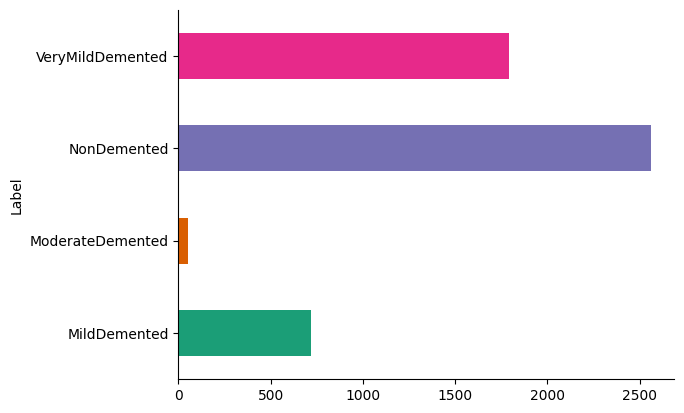

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Image path: dataset/Training Images/nonDem1072.jpg
Label: NonDemented
Image path: dataset/Training Images/nonDem718.jpg
Label: NonDemented
Image path: dataset/Training Images/verymildDem1023.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/nonDem772.jpg
Label: NonDemented
Image path: dataset/Training Images/nonDem996.jpg
Label: NonDemented
Image path: dataset/Training Images/nonDem396.jpg
Label: NonDemented


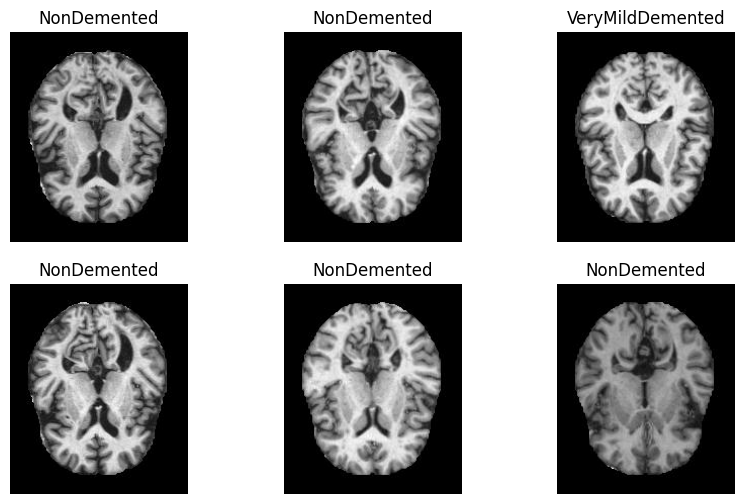

In [11]:
plt.figure(figsize=(10, 6))

for i, idx in enumerate(np.random.choice(len(data), 6)):
    im_path = data.loc[idx, 'Image']  
    label = data.loc[idx, 'Label']    

    print("Image path:", im_path)
    print("Label:", label)


    img = cv2.imread(im_path)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Training Setup

In [12]:
id2label = {str(i): c for i, c in enumerate(data.Label.unique())}
label2id = {c: str(i) for i, c in id2label.items()}

id2label

{'0': 'MildDemented',
 '1': 'ModerateDemented',
 '2': 'NonDemented',
 '3': 'VeryMildDemented'}

In [13]:
data.Label = data.Label.map(lambda x: int(label2id[x]))

In [14]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,0
1,dataset/Training Images/mildDem1.jpg,0
2,dataset/Training Images/mildDem10.jpg,0
3,dataset/Training Images/mildDem100.jpg,0
4,dataset/Training Images/mildDem101.jpg,0
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,3
5117,dataset/Training Images/verymildDem996.jpg,3
5118,dataset/Training Images/verymildDem997.jpg,3
5119,dataset/Training Images/verymildDem998.jpg,3


In [15]:
image_counts = data['Label'].value_counts()
print(image_counts)

Label
2    2560
3    1792
0     717
1      52
Name: count, dtype: int64


In [24]:
import albumentations as A
import cv2
import os
from uuid import uuid4

initial_counts = {
    '2': 2560,  # NonDemented
    '3': 1792,  # VeryMildDemented
    '0': 717,   # MildDemented
    '1': 52     # ModerateDemented
}

target_augmentations = {
    '2': 3900,  # NonDemented
    '3': 3700,  # VeryMildDemented
    '0': 4700,  # MildDemented
    '1': 5000   # ModerateDemented
}

target_count = 5000

def apply_augmentations(image):
    transform = A.Compose([
        A.RandomBrightnessContrast(p=1),
        A.Rotate(limit=(-180, 180), p=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomResizedCrop(height=image.shape[0], width=image.shape[1], p=0.5)
    ])
    return transform(image=image)['image']


!rm -rf augmented_dataset
for id in initial_counts.keys():
    os.makedirs(f'augmented_dataset/{id}', exist_ok=True)


for _, row in data.iterrows():
    img_path, label = row['Image'], row['Label']
    label = str(label)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image at {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_name = str(uuid4())
    initial_img_path = f'augmented_dataset/{label}/{img_name}_0.png'
    cv2.imwrite(initial_img_path, img)

    
    augmentations_needed = target_augmentations[label] // initial_counts[label]
    total_images_created = 1  

    for i in range(augmentations_needed):
        if total_images_created < target_count - initial_counts[label]:
            augmented_img = apply_augmentations(img)
            augmented_img_path = f'augmented_dataset/{label}/{img_name}_{i+1}.png'
            cv2.imwrite(augmented_img_path, augmented_img)
            total_images_created += 1
        else:
            extra_img_path = f'augmented_dataset/{label}/{img_name}_copy_{i+1}.png'
            cv2.imwrite(extra_img_path, img)
            total_images_created += 1
        if total_images_created >= target_count - initial_counts[label]:
            break


In [25]:
import os
augmented_dataset_path = 'augmented_dataset'

image_counts = {}

for label in os.listdir(augmented_dataset_path):
    label_path = os.path.join(augmented_dataset_path, label)
    count = len(os.listdir(label_path))
    image_counts[label] = count

print("Number of images per class in the augmented dataset:")
for label, count in image_counts.items():
    print(f"Label {label}: {count} images")


Number of images per class in the augmented dataset:
Label 2: 5120 images
Label 1: 5044 images
Label 0: 5019 images
Label 3: 5376 images


## Resnet

In [27]:
import torch
import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [28]:
def get_transforms(train=True):
    return transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [29]:

dataset = ImageFolder('augmented_dataset', transform=get_transforms())
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_val_dataset = ImageFolder('augmented_dataset', transform=get_transforms(train=True))
test_dataset = ImageFolder('dataset/Testing Images', transform=get_transforms(train=False))

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [30]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
import pandas as pd
import os
import shutil

csv_path = 'dataset/Training.csv'
current_image_dir = 'dataset/Training Images'

output_dir = 'dataset/labels_training'

df = pd.read_csv(csv_path)

os.makedirs(output_dir, exist_ok=True)

for index, row in df.iterrows():
    image_path = os.path.join(current_image_dir, row['Image'])  
    label = row['Label']
    label_dir = os.path.join(output_dir, str(label))

    os.makedirs(label_dir, exist_ok=True)

    new_image_path = os.path.join(label_dir, os.path.basename(image_path))

    shutil.copy(image_path, new_image_path)  

print("Images have been organized into subfolders based on their labels.")


Images have been organized into subfolders based on their labels.


In [ ]:
import os

augmented_dataset_path = 'dataset/labels_training'

image_counts = {}

for label in os.listdir(augmented_dataset_path):
    label_path = os.path.join(augmented_dataset_path, label)
    count = len(os.listdir(label_path))
    image_counts[label] = count

print("Number of images per class in the labelled training dataset:")
for label, count in image_counts.items():
    print(f"Label {label}: {count} images")


Number of images per class in the labelled training dataset:
Label ModerateDemented: 52 images
Label NonDemented: 2560 images
Label VeryMildDemented: 1792 images
Label MildDemented: 717 images


In [ ]:
import torch
from torch import nn

dataset2 = ImageFolder('dataset/labels_training', transform=get_transforms())
def compute_class_weights(dataset):
    class_counts = {}
    for _, label in dataset:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

    total = sum(class_counts.values())

    weights = {cls: total / count for cls, count in class_counts.items()}

    weight_list = [weights[i] for i in range(len(class_counts))]

    return torch.tensor(weight_list, dtype=torch.float)

weights = compute_class_weights(dataset2)
print(weights)
weights = weights.to(device) 


tensor([ 7.1423, 98.4808,  2.0004,  2.8577])


In [33]:
import torch.optim as optim
import torch.nn as nn
from torchvision import models

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


In [34]:
num_epochs = 20
for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    print(f'Epoch {epoch+1}: Train Loss: {total_loss / len(train_loader.dataset):.4f}')

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Loss: {val_loss / len(val_loader.dataset):.4f}, Accuracy: {100 * correct / total:.2f}%')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: Train Loss: 0.8612
Validation Loss: 0.7986, Accuracy: 67.56%
Epoch 2: Train Loss: 0.5439
Validation Loss: 0.5478, Accuracy: 78.65%
Epoch 3: Train Loss: 0.3515
Validation Loss: 0.5395, Accuracy: 79.62%
Epoch 4: Train Loss: 0.2480
Validation Loss: 0.5667, Accuracy: 80.20%
Epoch 5: Train Loss: 0.1677
Validation Loss: 0.4936, Accuracy: 83.66%
Epoch 6: Train Loss: 0.1209
Validation Loss: 0.5400, Accuracy: 82.86%
Epoch 7: Train Loss: 0.0896
Validation Loss: 0.6345, Accuracy: 82.37%
Epoch 8: Train Loss: 0.0815
Validation Loss: 0.7247, Accuracy: 80.71%
Epoch 9: Train Loss: 0.0750
Validation Loss: 0.6123, Accuracy: 83.34%
Epoch 10: Train Loss: 0.0488
Validation Loss: 0.6136, Accuracy: 83.88%
Epoch 11: Train Loss: 0.0533
Validation Loss: 0.6281, Accuracy: 84.92%
Epoch 12: Train Loss: 0.0352
Validation Loss: 0.6768, Accuracy: 85.04%
Epoch 13: Train Loss: 0.0299
Validation Loss: 0.6552, Accuracy: 84.82%
Epoch 14: Train Loss: 0.0241
Validation Loss: 0.7336, Accuracy: 83.51%
Epoch 15: Train

In [35]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI Project/resnet50_v4_20.pth')

In [36]:
def get_predictions(model, data_loader):
    model.eval()  
    predictions = []
    actual_labels = []
    with torch.no_grad(): 
        for images, labels in data_loader:
            images = images.to(device)  
            labels = labels.to(device)  
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  
            predictions.extend(preds.cpu().numpy())  
            actual_labels.extend(labels.cpu().numpy())  
    return actual_labels, predictions


In [37]:
from sklearn.metrics import classification_report

labels, preds = get_predictions(model, test_loader)
print(classification_report(labels, preds, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']))  # Adjust class names as needed


                  precision    recall  f1-score   support

    MildDemented       0.95      0.35      0.51       179
ModerateDemented       0.43      1.00      0.60        12
     NonDemented       0.69      0.93      0.79       640
VeryMildDemented       0.82      0.59      0.68       448

        accuracy                           0.73      1279
       macro avg       0.72      0.72      0.65      1279
    weighted avg       0.77      0.73      0.71      1279



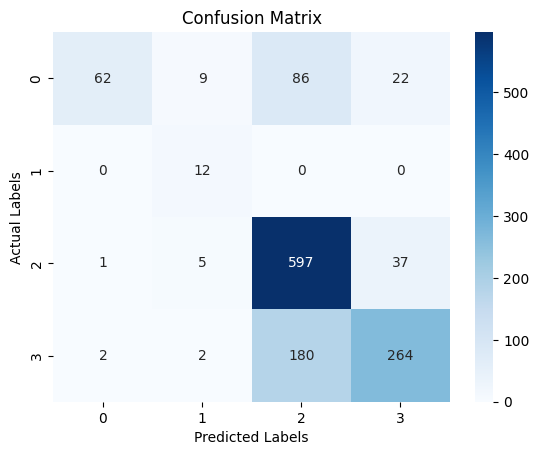

In [38]:
conf_matrix = confusion_matrix(labels, preds)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()
